In [10]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")
include("polyagamma.jl");

In [11]:
d, Nobs = 10, 100
X = sprandn(d, Nobs, 5e-1)
ξ_true = sprandn(d, 5e-1)
ξ_true[1] = randn()
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

In [12]:
σ02 = 1
# prior = HS_prior(d, σ02)
# prior = gaussian_prior_nh(d, σ02)
prior = SS_prior(d, σ02)
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior);

In [13]:
mb_size = 20
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.8
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

In [14]:
opt = maxa_opt(10^6)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

In [15]:
adapt_speed = "by_var" 
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e1)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [16]:
h = 5e-1
xi_samples = zz_samples(mstate, h) 
pr_samples = hyp_samples(prior, h);

In [17]:
ZZ_block_sample_discrete(my_model, opt, blocksampler, mstate, xi_samples, pr_samples)

10% attempts in 0.44 mins 
20% attempts in 0.89 mins 
30% attempts in 1.35 mins 
40% attempts in 1.83 mins 
50% attempts in 2.32 mins 
60% attempts in 2.83 mins 
70% attempts in 3.36 mins 
80% attempts in 3.91 mins 
90% attempts in 4.47 mins 
100% attempts in 5.04 mins 


In [18]:
xi_samples.lastsamplet == pr_samples.lastsamplet

true

In [19]:
print(sum(mstate.n_bounces), " zz bounces \n")
print(hyper_sampler.nbounces, " hyper bounces")

33836 zz bounces 
13382 hyper bounces

In [20]:
size(xi_samples.samples,2)

2674

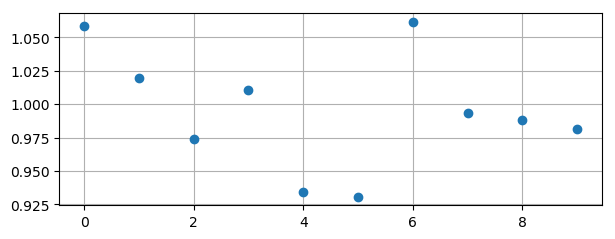

In [21]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples.samples, pr_samples.samples, k) for k in 1:d], "o")
grid(true)

In [22]:
maxlag = 50
acfs_xi = zeros(d, maxlag)
acfs_hyp = zeros(size(pr_samples.samples,1), maxlag)

for i in 1:d 
    acfs_xi[i,:] = acf(xi_samples.samples[i,:], maxlag)
end
for i in 1:size(pr_samples.samples,1)
    acfs_hyp[i,:] = acf(pr_samples.samples[i,:], maxlag)
end

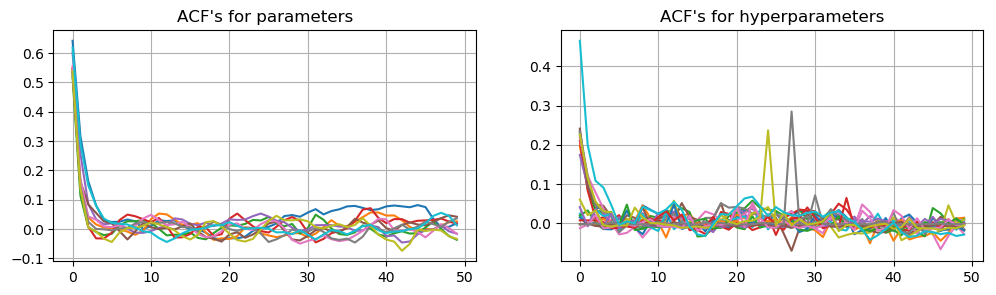

In [23]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_xi[i,:])
end
grid(true)
title("ACF's for parameters")

subplot(122)
for i in 1:size(pr_samples.samples,1) 
    plot(acfs_hyp[i,:])
end
grid(true)
title("ACF's for hyperparameters");